# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

# 이미지 세그멘테이션(Image Segmentation)



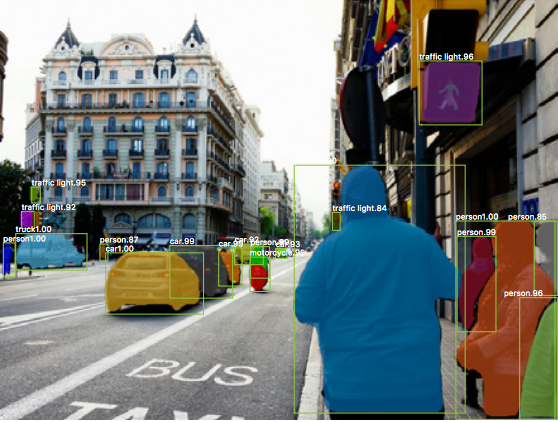

# U-Net 기반 세그멘테이션

- 사용된 모델은 수정된 U-Net(https://arxiv.org/abs/1505.04597)
- U-Net이라 불리는 인코더(다운샘플링)와 디코더(업샘플링)를 포함한 구조는 정교한 픽셀 단위의 segmentation이 요구되는 biomedical image segmentation task의 핵심 요소
- Encoder-decoder 구조 또한 semantic segmentation을 위한 CNN 구조로 자주 활용
- Encoder 부분에서는 점진적으로 spatial dimension을 줄여가면서 고차원의 semantic 정보를 convolution filter가 추출해낼 수 있게 함
- Decoder 부분에서는 encoder에서 spatial dimension 축소로 인해 손실된 spatial 정보를 점진적으로 복원하여 보다 정교한 boundary segmentation을 완성
- U-Net은 기본적인 encoder-decoder 구조와 달리 Spatial 정보를 복원하는 과정에서 이전 encoder feature map 중 동일한 크기를 지닌 feature map을 가져 와 prior로 활용함으로써 더 정확한 boundary segmentation이 가능하게 함

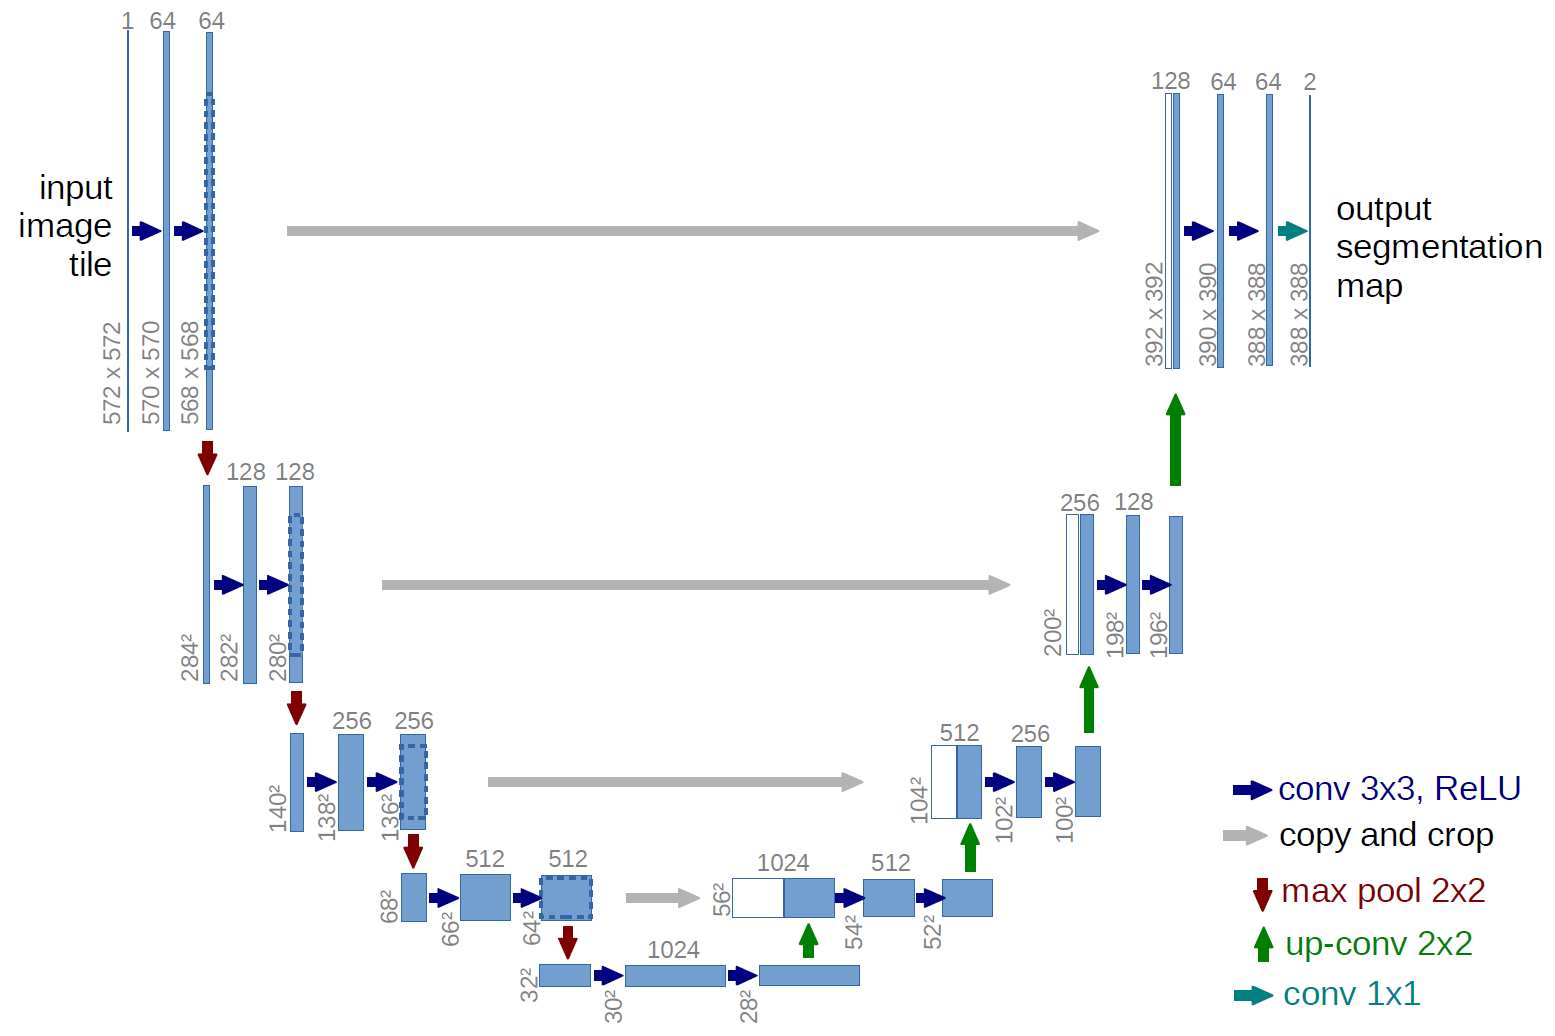

## Download the data

### Oxford-IIIT Pets 데이터셋

- Parkhi *et al*이 만든 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) 데이터 세트는 영상, 해당 레이블과 픽셀 단위의 마스크로 구성
- 마스크는 각 픽셀의 레이블
- 각 픽셀은 다음 세 가지 범주 중 하나
  *   class 1 : 애완동물이 속한 픽셀
  *   class 2 : 애완동물과 인접한 픽셀
  *   class 3 : 위에 속하지 않는 경우/주변 픽셀

- Images: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
- Annotations: https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

!curl -L https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -o images.tar.gz
!curl -L https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -o annotations.tar.gz
!tar -zxvf images.tar.gz
!tar -zxvf annotations.tar.gz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [ ]:
!ls

annotations  annotations.tar.gz  images  images.tar.gz	sample_data


In [ ]:
!ls annotations #trimaps가 정답값

list.txt  README  test.txt  trainval.txt  trimaps  xmls


## Prepare paths of input images and target segmentation masks

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/" #annotation을 한 결과에 대해서 dir 지정
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname) #리스트를 문자열로 일정하게 합쳐주는 join함수를 이용해서 image와 file name을 가져옴
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".") #결과는 png파일로 나옴
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## 위의 리스트를 이미지로 가져와서 확인해보기

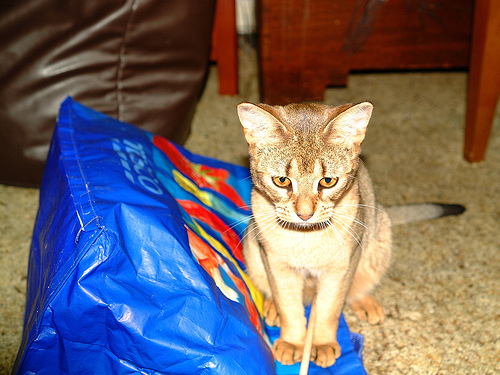

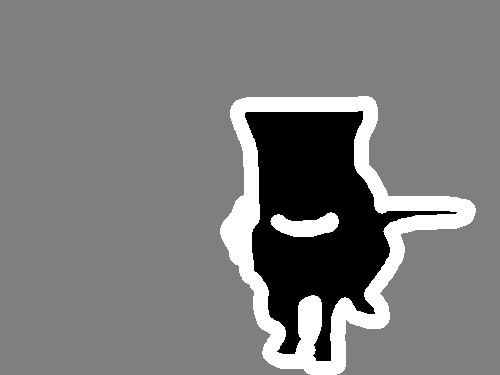

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[7]))

# Display auto-contrast version of corresponding target (per-pixel categories)-이미지에 해당하는 정답 annotation image도 같이 출력
img = ImageOps.autocontrast(load_img(target_img_paths[7])) #autocontrast를 통해서 자동으로 조정
display(img)

## Prepare `Sequence` class to load & vectorize batches of data-데이터를 편하게 쓸 수 있도록 만드는 데이터 전처리 과정

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):#keras.utils.Sequence를 상속 받는 OxfordPets라는 클래스 선언
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):#클래스에서 초기화로 사용할 부분들을 넣어줌
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size] #batch단위로 input_img_paths를 가져오므로 (예[0:32])
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") #batch size 단위로 공간을 만들어 줌, 컬러 이미지이므로 3
        for j, path in enumerate(batch_input_img_paths): #j는 해당하는 인덱스
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8") #결과는 흑백이미지(grayscale)이므로 1
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1 #원 데이터에서는 label이 1,2,3으로 되어있지만 class 0,1,2로 표기할 것이므로 -1을 해줌
        return x, y


## Prepare U-Net Xception-style model

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x) #SeparableConv2D가 구조적으로 이점이 있어 사용
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x) #upsampling을 할 때는 Conv2DTranspose사용
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual 
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer-확률적으로 어느 클래스에 해당하는지 보여줘야 하므로 softmax
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary() #U형태이므로 parameter 개수가 많음을 알 수 있음

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples] #뒷부분 1000개 외에는 train
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:] #뒷부분 1000개 나머지는 val
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
] #중간중간 괜찮은 결과가 나오면 그 결과들을 callback으로 저장할 수 있도록 함

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 52s 186ms/step - loss: 0.8833 - val_loss: 1.7064
Epoch 2/15
199/199 [==============================] - 36s 181ms/step - loss: 0.4999 - val_loss: 2.0145
Epoch 3/15
199/199 [==============================] - 36s 182ms/step - loss: 0.4253 - val_loss: 0.4701
Epoch 4/15
199/199 [==============================] - 36s 181ms/step - loss: 0.3827 - val_loss: 0.3996
Epoch 5/15
199/199 [==============================] - 36s 180ms/step - loss: 0.3461 - val_loss: 0.4448
Epoch 6/15
199/199 [==============================] - 36s 182ms/step - loss: 0.3197 - val_loss: 0.3911
Epoch 7/15
199/199 [==============================] - 36s 182ms/step - loss: 0.2949 - val_loss: 0.3707
Epoch 8/15
199/199 [==============================] - 36s 180ms/step - loss: 0.2718 - val_loss: 0.3746
Epoch 9/15
199/199 [==============================] - 36s 180ms/step - loss: 0.2522 - val_loss: 0.4082
Epoch 10/15
199/199 [==============================] - 36s 180ms/step - l

## Visualize predictions

31/31 [==============================] - 5s 153ms/step


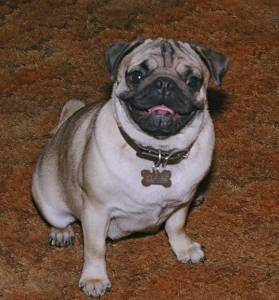

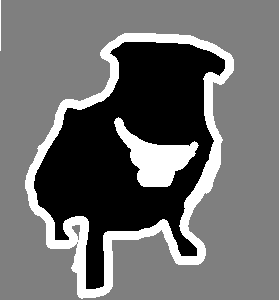

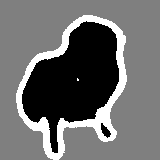

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.